In [1]:
from PIL import Image, ImageDraw, ImageFilter
import os
import random
from matplotlib.pyplot import imshow
%matplotlib inline


backgrounds_folder='./backgrounds'
signs_folder='./signs'
backgrounds=os.listdir(backgrounds_folder)
signs=os.listdir(signs_folder)

(100, 100)


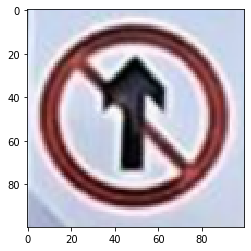

In [2]:
sign=Image.open(signs_folder+'/'+signs[11])
sign=sign.resize((100,100))
print(sign.size)
imshow(sign)

(800, 600)


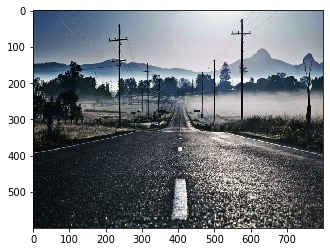

In [3]:
background=Image.open(backgrounds_folder+'/'+backgrounds[5])
background=background.resize((800,600))
print(background.size)
imshow(background)

In [4]:
mask_im = Image.new("L", sign.size, 0)
draw = ImageDraw.Draw(mask_im)
draw.ellipse((0, 0, sign.size[0], sign.size[1]), fill=255)
mask_im_blur = mask_im.filter(ImageFilter.GaussianBlur(5)) # Is there a better way than this GaussianBlur?

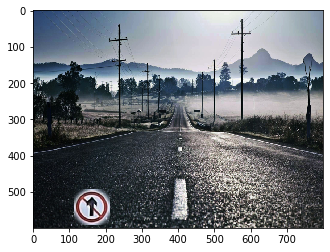

In [5]:
top_left_x=random.randint(0,background.size[0]-sign.size[0])
top_left_y=random.randint(0,background.size[1]-sign.size[1])
background.paste(sign, (top_left_x, top_left_y), mask_im_blur)
imshow(background)

In [6]:
label=[(top_left_x, top_left_y),(top_left_x+sign.size[0], top_left_y+sign.size[1])]
print(label)

[(113, 493), (213, 593)]
